In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp

In [2]:
fibroblast = sc.read_h5ad("/mnt/d/dailywork/01_Smear_seq/cancer/eso_squamou_cancer/data_analysis/fibroblast/fibroblast_GSE203115.h5ad")

In [3]:
fibroblast

AnnData object with n_obs × n_vars = 1248 × 16948
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes', 'patients', 'response', 'leiden', 'anno', 'sub_anno'
    var: 'gene_ids', 'feature_types', 'mt', 'rb', 'hb', 'hsp', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'anno_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patients_colors', 'pca', 'rank_genes_groups', 'response_colors', 'sub_anno_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

In [4]:
def kegg_enrichment(gene_list, file_name_prefix):
    # enrichment analysis
    enr = gp.enrich(gene_list,
                    gene_sets="KEGG_2021_Human",
                    outdir=None)
    # filtering p value is more than 0.05
    result = enr.res2d[enr.res2d['P-value'] < 0.05]
    # save result
    result.to_csv(f"/mnt/c/Users/ouyangkang/Desktop/{file_name_prefix}_result.csv", index=None)

    return result

In [5]:
# DEGs extraction
result = fibroblast.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [55]:
map_df = fibroblast.obs[['leiden', 'sub_anno']]
map_df = map_df.drop_duplicates(subset=['leiden'], keep='first')

tmp_dir = {}
for i in range(9):
    idx = str(i)
    tem_df = degs[degs.columns[degs.columns.str.contains(idx)]]
    tem_df = tem_df[tem_df[idx + "_logfoldchanges"] > 1]
    tem_df = tem_df[tem_df[idx + "_pvals"] < 0.05]
    key = map_df[map_df['leiden'] == idx]['sub_anno'].values[0]
    tmp_dir[key] = tem_df[idx + "_names"].tolist()[:18]

In [58]:
pd.DataFrame(tmp_dir).to_csv('/mnt/d/dailywork/01_Smear_seq/cancer/eso_squamou_cancer/geo/GSE53625/fibroblast.csv', index=None)

In [15]:
# create a empty list to temporarily save result data frame
result_list = []
for i in range(9):
    part_genes = degs[degs.columns[degs.columns.str.contains(str(i))]].head(50)[str(i) + "_names"]
    result = kegg_enrichment(part_genes, str(i))
    result["group"] = i
    result_list += [result]

final_result = pd.concat(result_list, ignore_index=True)

In [16]:
final_result.shape

(229, 11)

In [17]:
final_result.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,group
0,KEGG_2021_Human,Antigen processing and presentation,5/78,0.000001,0.000102,0,0,30.254186,406.460876,HLA-B;HLA-C;HLA-A;B2M;CTSB,0
1,KEGG_2021_Human,Allograft rejection,3/38,0.000117,0.002141,0,0,36.319149,328.932133,HLA-B;HLA-C;HLA-A,0
2,KEGG_2021_Human,Epstein-Barr virus infection,5/202,0.000146,0.002141,0,0,11.141004,98.358647,HLA-B;HLA-C;ISG15;HLA-A;B2M,0
3,KEGG_2021_Human,Graft-versus-host disease,3/42,0.000158,0.002141,0,0,32.587561,285.325282,HLA-B;HLA-C;HLA-A,0
4,KEGG_2021_Human,Type I diabetes mellitus,3/43,0.000169,0.002141,0,0,31.771277,275.936322,HLA-B;HLA-C;HLA-A,0
5,KEGG_2021_Human,Human immunodeficiency virus 1 infection,5/212,0.000184,0.002141,0,0,10.597424,91.172624,BST2;HLA-B;HLA-C;HLA-A;B2M,0
6,KEGG_2021_Human,Autoimmune thyroid disease,3/53,0.000315,0.003154,0,0,25.404255,204.802610,HLA-B;HLA-C;HLA-A,0
7,KEGG_2021_Human,Viral myocarditis,3/60,0.000455,0.003982,0,0,22.276596,171.420098,HLA-B;HLA-C;HLA-A,0
8,KEGG_2021_Human,Human papillomavirus infection,5/331,0.001387,0.010784,0,0,6.688480,44.016584,WNT5A;HLA-B;HLA-C;ISG15;HLA-A,0
9,KEGG_2021_Human,Human T-cell leukemia virus 1 infection,4/219,0.002172,0.013879,0,0,7.981800,48.946059,HLA-B;HLA-C;HLA-A;B2M,0


In [30]:
# transform from wide data to long data
p_term_df = final_result.pivot(index="Term", columns="group", values="P-value")
# fill na with 1, which will be -log10() 
p_term_df.fillna(1, inplace=True)
# delete useless name
p_term_df.index.name = None
p_term_df.columns.name = None
# -log(10)
p_term_df = -np.log10(p_term_df)
'''
# Z-score
p_term_df = (p_term_df - p_term_df.mean()) / p_term_df.std()
'''
p_term_df.head()

,0,1,2,3,4,5,6,7,8
AGE-RAGE signaling pathway in diabetic complications,-0.000000,-0.0,-0.0,3.944747,-0.0,5.300387,-0.000000,2.697956,-0.0000
Adherens junction,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.000000,4.527540,-0.000000,-0.0000
Adrenergic signaling in cardiomyocytes,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.000000,2.203206,-0.000000,-0.0000
Allograft rejection,3.933281,-0.0,-0.0,2.390890,-0.0,-0.000000,2.390890,-0.000000,9.3327
Amoebiasis,-0.000000,-0.0,-0.0,3.911417,-0.0,3.911417,1.569962,1.569962,-0.0000


In [48]:
plot_df = p_term_df.loc[
    [
        # cluster 0
        "Antigen processing and presentation", "Allograft rejection", "Protein digestion and absorption",
        # cluster 1
        "Complement and coagulation cascades", "Proteoglycans in cancer",
        # cluster 2
        "Metabolism of xenobiotics by cytochrome P450", "PI3K-Akt signaling pathway", "Ras signaling pathway",
        # cluster 3
        "Protein digestion and absorption", "ECM-receptor interaction", "Focal adhesion", "Platelet activation",
        # cluster 4
        "Fc gamma R-mediated phagocytosis",
        # cluster 6
        "Regulation of actin cytoskeleton", "Tight junction", "Vascular smooth muscle contraction",
        # cluster 7
        "IL-17 signaling pathway", "TNF signaling pathway", "NOD-like receptor signaling pathway",
        # cluster 8
        "Th1 and Th2 cell differentiation", "Th17 cell differentiation", "T cell receptor signaling pathway"
    ]
]
plot_df.head()

,0,1,2,3,4,5,6,7,8
Antigen processing and presentation,5.834687,-0.000000,-0.000000,3.008679,-0.000000,-0.000000,4.366379,-0.0,9.041112
Allograft rejection,3.933281,-0.000000,-0.000000,2.390890,-0.000000,-0.000000,2.390890,-0.0,9.332700
Protein digestion and absorption,2.661339,-0.000000,-0.000000,14.908682,-0.000000,11.425880,1.562130,-0.0,-0.000000
Complement and coagulation cascades,-0.000000,2.900631,2.900631,-0.000000,4.219832,-0.000000,-0.000000,-0.0,-0.000000
Proteoglycans in cancer,-0.000000,1.835392,-0.000000,2.767660,1.835392,4.929507,1.835392,-0.0,-0.000000


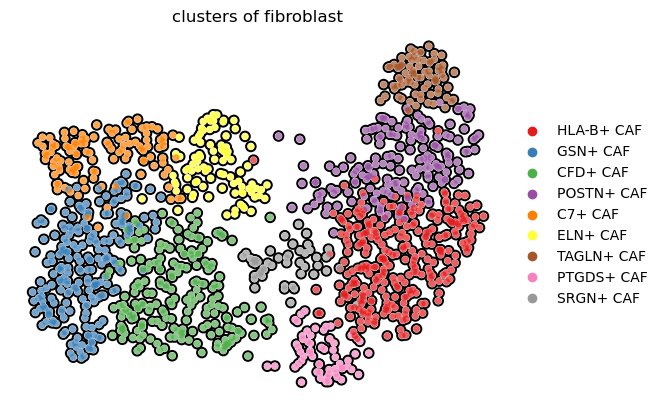

In [24]:
sc.pl.umap(fibroblast, color="sub_anno", frameon=False, add_outline=True, palette="Set1", title="clusters of fibroblast")

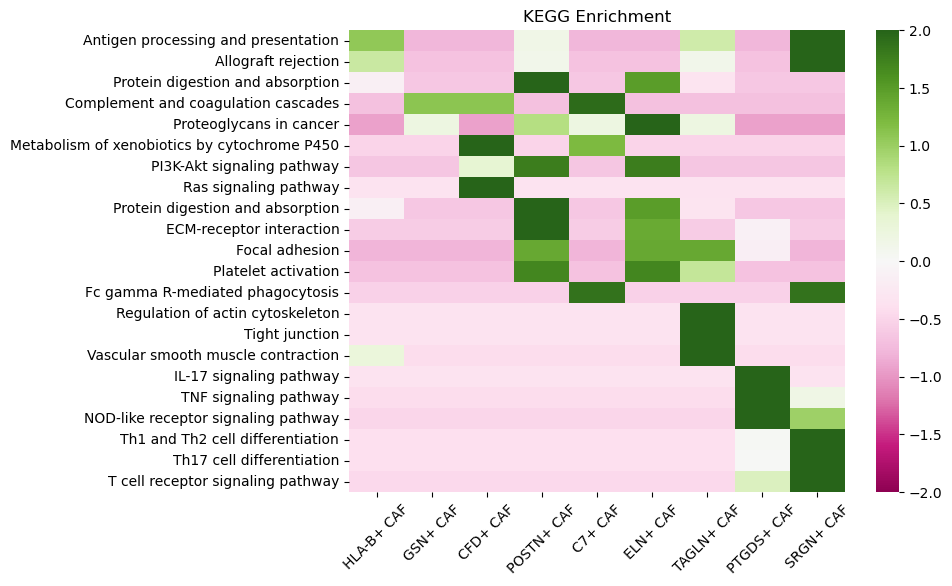

In [49]:
import seaborn as sns
from scipy.stats import zscore

plot_df = plot_df.apply(zscore, axis=1)
plot_df.columns = ["HLA-B+ CAF", "GSN+ CAF", "CFD+ CAF", "POSTN+ CAF", "C7+ CAF", "ELN+ CAF", "TAGLN+ CAF", "PTGDS+ CAF", "SRGN+ CAF"]
plt.figure(figsize=(8, 6))
sns.heatmap(plot_df, cmap="PiYG", vmin=-2, vmax=2)
plt.xticks(rotation=45)
plt.title("KEGG Enrichment")
plt.show()

In [44]:
plot_df.max()

HLA-B+ CAF    2.403066
GSN+ CAF      1.106558
CFD+ CAF      2.828427
POSTN+ CAF    2.255591
C7+ CAF       1.923361
ELN+ CAF      2.180373
TAGLN+ CAF    2.828427
PTGDS+ CAF    2.828427
SRGN+ CAF     2.828427
dtype: float64